
Circles Dataset:


<ipython-input-16-fff5dd906374>:104: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  node1, node2 = random.sample(component, 2)


Generation 0: Minimum Trees = 5
Generation 1: Minimum Trees = 2
Generation 2: Minimum Trees = 2
Generation 3: Minimum Trees = 2
Generation 4: Minimum Trees = 2
Generation 5: Minimum Trees = 2
Generation 6: Minimum Trees = 2


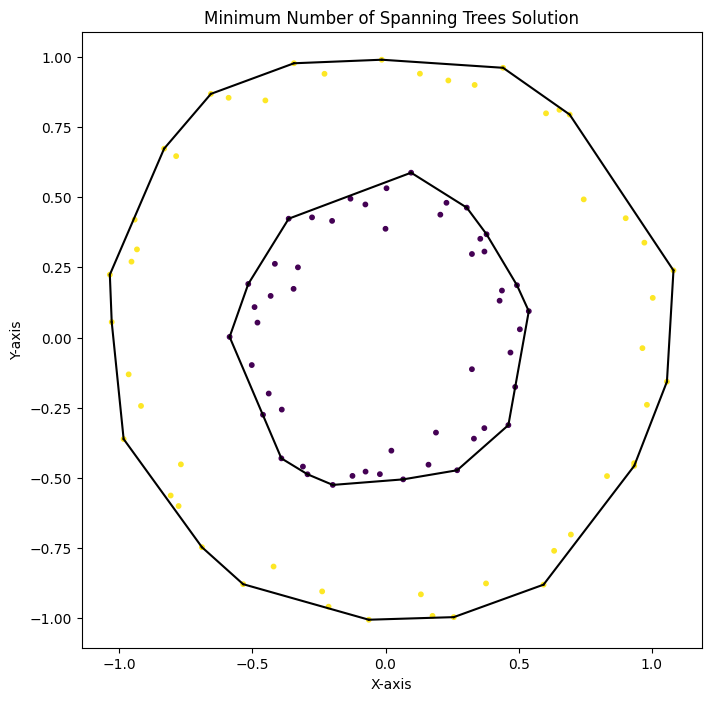


Blobs Dataset:
Generation 0: Minimum Trees = 4
Generation 1: Minimum Trees = 3
Generation 2: Minimum Trees = 3
Generation 3: Minimum Trees = 3
Generation 4: Minimum Trees = 3
Generation 5: Minimum Trees = 3
Generation 6: Minimum Trees = 3


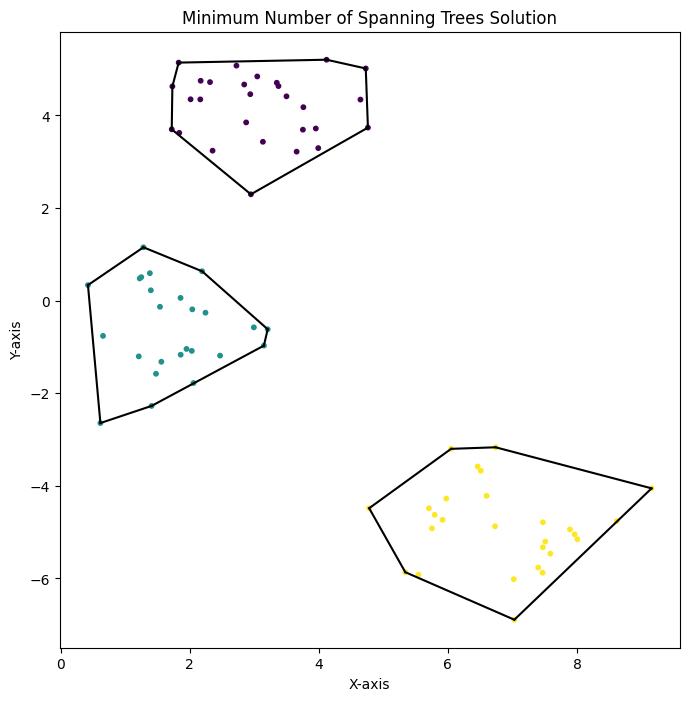


Moons Dataset:
Generation 0: Minimum Trees = 2
Generation 1: Minimum Trees = 2
Generation 2: Minimum Trees = 2
Generation 3: Minimum Trees = 2
Generation 4: Minimum Trees = 2
Generation 5: Minimum Trees = 2
Generation 6: Minimum Trees = 2


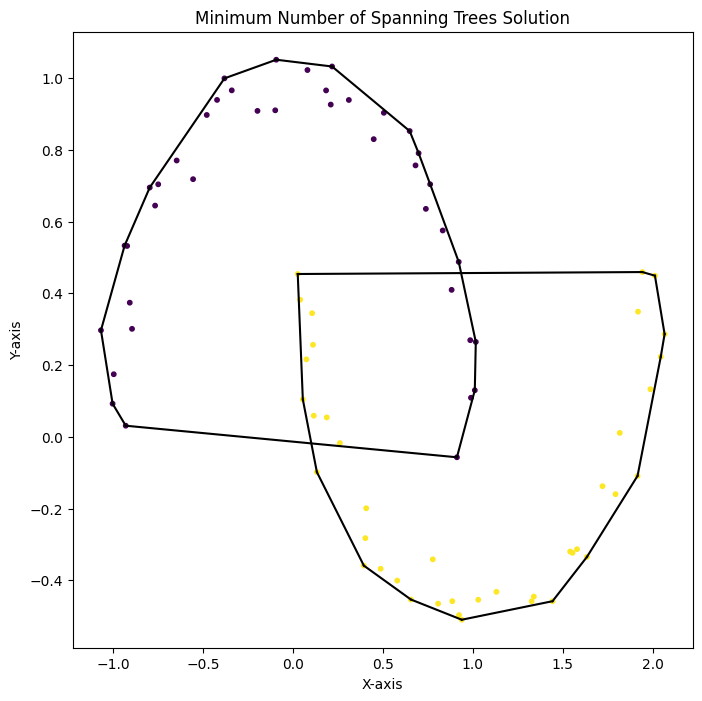

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles, make_blobs, make_moons
from scipy.spatial.distance import pdist, squareform
import networkx as nx
import random
from scipy.spatial import ConvexHull

# Generate a sample circle dataset
def generate_circle_data(n_samples=100, noise=0.05):
    X, _ = make_circles(n_samples=n_samples, factor=0.5, noise=noise)
    return X

# Generate a sample blobs dataset
def generate_blobs_data(n_samples=100, centers=3, cluster_std=1.0):
    X, _ = make_blobs(n_samples=n_samples, centers=centers, cluster_std=cluster_std)
    return X

# Generate a sample moons dataset
def generate_moons_data(n_samples=100, noise=0.1):
    X, _ = make_moons(n_samples=n_samples, noise=noise)
    return X

# Calculate the distance matrix
def calculate_distance_matrix(data):
    return squareform(pdist(data))

# Genetic Algorithm to find the minimum number of spanning trees
class GeneticAlgorithmMST:
    def __init__(self, data, distance_threshold, population_size=100, generations=200, mutation_rate=0.1):
        self.data = data
        self.distance_matrix = calculate_distance_matrix(data)
        self.distance_threshold = distance_threshold
        self.population_size = population_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.num_points = len(data)
        self.population = self.initialize_population()

    def initialize_population(self):
        population = []
        for _ in range(self.population_size):
            individual = self.create_random_spanning_forest()
            population.append(individual)
        return population

    def create_random_spanning_forest(self):
        graph = nx.Graph()
        graph.add_nodes_from(range(self.num_points))
        edges = [(i, j) for i in range(self.num_points) for j in range(i + 1, self.num_points) if self.distance_matrix[i, j] <= self.distance_threshold]
        graph.add_edges_from(random.sample(edges, min(len(edges), self.num_points - 1)))  # Ensure feasible edges

        # Ensure connected components don't exceed distance threshold
        components = list(nx.connected_components(graph))
        return components

    def fitness(self, individual):
        # Fitness is measured by the number of trees (components) in the solution
        return len(individual)

    def selection(self):
        # Select individuals based on their fitness (tournament selection)
        selected = []
        for _ in range(self.population_size):
            i, j = random.sample(range(len(self.population)), 2)  # Use current population length
            selected.append(min(self.population[i], self.population[j], key=self.fitness))
        return selected

    def crossover(self, parent1, parent2):
        # Crossover two parents to create a child
        graph1 = self.create_graph_from_components(parent1)
        graph2 = self.create_graph_from_components(parent2)
        graph_union = nx.compose(graph1, graph2)

        # Find spanning trees in the union graph
        components = list(nx.connected_components(graph_union))
        child = []
        for component in components:
            subgraph = graph_union.subgraph(component)
            mst = nx.minimum_spanning_tree(subgraph)
            child.append(set(mst.nodes))
        return child

    def create_graph_from_components(self, components):
        graph = nx.Graph()
        for component in components:
            for node in component:
                graph.add_node(node)
            for i in component:
                for j in component:
                    if i != j and self.distance_matrix[i, j] <= self.distance_threshold:
                        graph.add_edge(i, j)
        return graph

    def mutate(self, individual):
        # Randomly mutate an individual by modifying its edges
        if random.random() < self.mutation_rate:
            graph = self.create_graph_from_components(individual)
            all_nodes = set(range(self.num_points))
            for component in individual:
                if random.random() < self.mutation_rate:
                    # Try to add a new edge within a component
                    if len(component) > 1:
                        node1, node2 = random.sample(component, 2)
                        if self.distance_matrix[node1, node2] <= self.distance_threshold:
                            graph.add_edge(node1, node2)
                    # Try to add a new edge between components
                    remaining_nodes = all_nodes - component
                    if remaining_nodes:
                        node1 = random.choice(list(component))
                        node2 = random.choice(list(remaining_nodes))
                        if self.distance_matrix[node1, node2] <= self.distance_threshold:
                            graph.add_edge(node1, node2)

            components = list(nx.connected_components(graph))
            return components
        return individual

    def evolve(self):
        for generation in range(self.generations):
            selected = self.selection()
            new_population = []
            for i in range(0, self.population_size, 2):
                parent1, parent2 = selected[i], selected[i + 1]
                child = self.crossover(parent1, parent2)
                child = self.mutate(child)
                new_population.append(child)
            self.population = new_population

            # Print progress
            best_individual = min(self.population, key=self.fitness)
            print(f"Generation {generation}: Minimum Trees = {self.fitness(best_individual)}")

        # Return the best solution
        best_solution = min(self.population, key=self.fitness)
        return best_solution

    def cluster(self):
        # Perform clustering using the spanning trees
        best_solution = min(self.population, key=self.fitness)
        labels = np.full(self.num_points, -1, dtype=int)

        for cluster_id, component in enumerate(best_solution):
            for node in component:
                labels[node] = cluster_id

        return labels

def plot_solution(data, solution, labels):
    plt.figure(figsize=(8, 8))
    for component in solution:
        points = data[list(component)]
        if len(points) > 2:  # ConvexHull needs at least 3 points
            hull = ConvexHull(points)
            for simplex in hull.simplices:
                plt.plot(points[simplex, 0], points[simplex, 1], 'k-')
        else:  # Directly connect points if fewer than 3
            for i in range(len(points)):
                for j in range(i + 1, len(points)):
                    plt.plot(points[[i, j], 0], points[[i, j], 1], 'k-')
    plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', s=10)
    plt.title('Minimum Number of Spanning Trees Solution')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()

# Circles Dataset
data_circles = generate_circle_data(n_samples=100, noise=0.05)
distance_threshold_circles = 0.3
print("\nCircles Dataset:")
ga_mst_circles = GeneticAlgorithmMST(data_circles, distance_threshold_circles, population_size=50, generations=7, mutation_rate=0.1)
solution_circles = ga_mst_circles.evolve()
labels_circles = ga_mst_circles.cluster()
plot_solution(data_circles, solution_circles, labels_circles)

# Blobs Dataset
data_blobs = generate_blobs_data(n_samples=80, centers=3, cluster_std=0.9)
distance_threshold_blobs = 1.5
print("\nBlobs Dataset:")
ga_mst_blobs = GeneticAlgorithmMST(data_blobs, distance_threshold_blobs, population_size=50, generations=7, mutation_rate=0.1)
solution_blobs = ga_mst_blobs.evolve()
labels_blobs = ga_mst_blobs.cluster()
plot_solution(data_blobs, solution_blobs, labels_blobs)

# Moons Dataset
data_moons = generate_moons_data(n_samples=80, noise=0.05)
distance_threshold_moons = 0.3
print("\nMoons Dataset:")
ga_mst_moons = GeneticAlgorithmMST(data_moons, distance_threshold_moons, population_size=50, generations=7, mutation_rate=0.1)
solution_moons = ga_mst_moons.evolve()
labels_moons = ga_mst_moons.cluster()
plot_solution(data_moons, solution_moons, labels_moons)
